In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [2]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Buket
[nltk_data]     Fildisi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
stop_words.extend(['greenstoneplus','Source','Resources','Links'])

In [5]:
df= pd.read_excel('C:/Users/Buket Fildisi/Desktop/BCU/Dissertation/DEV/DATA/LinkedInParagraph.xlsx')
df.head()

Unnamed: 0                                            Context
0           0  SBTi recently published its fourth report titl...
1           1  Greenstone has curated an article that capture...
2           2  Established in 2014, The Science Based Targets...
3           3  SBTi prioritises emission reduction, offering ...
4           4  "SBTi Monitoring Report 2022 - Looking back at...

In [6]:
df=df.drop(df.columns[0], axis=1)
df.head()

Context
0  SBTi recently published its fourth report titl...
1  Greenstone has curated an article that capture...
2  Established in 2014, The Science Based Targets...
3  SBTi prioritises emission reduction, offering ...
4  "SBTi Monitoring Report 2022 - Looking back at...

In [7]:
df['Context']=df['Context'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
df

Context
0     SBTi recently published fourth report titled "...
1     Greenstone curated article captures key insigh...
2     Established 2014, Science Based Targets Initia...
3     SBTi prioritises emission reduction, offering ...
4     "SBTi Monitoring Report 2022 - Looking back 20...
...                                                 ...
1501  CDP’s disclosure platform provides mechanism r...
1502  Greenstone Gold Accredited CDP software partne...
1503         Using Greenstone’s software companies can:
1504  Define bespoke question sets range reporting f...
1505  well software, Greenstone provides clients sup...

[1506 rows x 1 columns]

In [8]:
df_list=df["Context"].values.tolist()
df_list

['SBTi recently published fourth report titled "SBTi Monitoring Report 2022 - Looking back 2022 moving forward 2023 beyond". comprehensive report delves worldwide advancements science-based targets reveals remarkable ongoing surge adoption science-targets companies financial institutions. trend persists despite escalating challenges prevalent global stage.',
 'Greenstone curated article captures key insights report.',
 'Established 2014, Science Based Targets Initiative (SBTi) collaboration among organisations including CDP, United Nations Global Compact, World Resources Institute (WRI), World Wide Fund Nature (WWF), Mean Business Coalition. assists global companies financial institutions setting science-based GHG emissions reduction targets, striving ambitious corporate climate action. SBTi mission involves aligning businesses climate science, cutting emissions, contributing goal limiting global warming 1.5°C.',
 'SBTi prioritises emission reduction, offering sector-specific guidance 

In [9]:
import string
import re
def text_clean_1(text):
    text = text.lower()
    text= text.replace(".  ",".");
    text= text.replace("'  ',","");
    text= text.replace(" '","'");
    text= text.replace("  ","");
    text= text.replace("▶ ","");
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [10]:
text_clean_1(df_list[3])

'sbti prioritises emission reduction offering sectorspecific guidance highemission industries facilitating action areas like maritime aviation approach aims make ambitious climate action mainstream across sectors urging necessary transformations netzero world includes collaboration large companies supply chains sbti believes multipronged approach effectively accelerate private sector emissions reduction harmony paris agreement'

In [11]:
len(df_list)

1506

In [12]:
doc=[]
for i in range(len(df_list)):
    doc.append(text_clean_1(df_list[i]))
doc

['sbti recently published fourth report titled sbti monitoring report 2022  looking back 2022 moving forward 2023 beyond comprehensive report delves worldwide advancements sciencebased targets reveals remarkable ongoing surge adoption sciencetargets companies financial institutions trend persists despite escalating challenges prevalent global stage',
 'greenstone curated article captures key insights report',
 'established 2014 science based targets initiative sbti collaboration among organisations including cdp united nations global compact world resources institute wri world wide fund nature wwf mean business coalition assists global companies financial institutions setting sciencebased ghg emissions reduction targets striving ambitious corporate climate action sbti mission involves aligning businesses climate science cutting emissions contributing goal limiting global warming 15°c',
 'sbti prioritises emission reduction offering sectorspecific guidance highemission industries facili

In [13]:
doc[1]

'greenstone curated article captures key insights report'

In [387]:
doc[1]

'greenstone curated article captures key insights report'

In [388]:
len(df)

1506

In [14]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
sentences=[]
tokenized_sentences=[]
for i in range(len(df)):
    #print(i)
    sentences.append(sent_tokenize(doc[i]))
    for sentence in sentences[i]:
        tokenized_sentences.append(word_tokenize(sentence.lower()))
sentences

[['sbti recently published fourth report titled sbti monitoring report 2022  looking back 2022 moving forward 2023 beyond comprehensive report delves worldwide advancements sciencebased targets reveals remarkable ongoing surge adoption sciencetargets companies financial institutions trend persists despite escalating challenges prevalent global stage'],
 ['greenstone curated article captures key insights report'],
 ['established 2014 science based targets initiative sbti collaboration among organisations including cdp united nations global compact world resources institute wri world wide fund nature wwf mean business coalition assists global companies financial institutions setting sciencebased ghg emissions reduction targets striving ambitious corporate climate action sbti mission involves aligning businesses climate science cutting emissions contributing goal limiting global warming 15°c'],
 ['sbti prioritises emission reduction offering sectorspecific guidance highemission industries

In [17]:
# Create bigram model
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram = Phrases(tokenized_sentences, min_count=2, threshold=50)
bigram_mod = Phraser(bigram)

# Apply the bigram model to the tokenized sentences
bigram_sentences = [bigram_mod[sentence] for sentence in tokenized_sentences]
bigram_sentences

# Generate trigram model
trigram = Phrases(bigram_sentences, min_count=2, threshold=10)
trigram_mod = Phraser(trigram)

# Apply trigram model to the bigram-transformed sentences
trigram_sentences = [trigram_mod[sentence] for sentence in bigram_sentences]

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bigram = lemmatization(bigram_sentences, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_bigram
data_lemmatized_trigram = lemmatization(trigram_sentences, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_trigram

[['sbti',
  'recently_publishe',
  'fourth',
  'report',
  'title',
  'sbti',
  'monitoring',
  'report',
  'look',
  'back',
  'move',
  'forward',
  'comprehensive',
  'report',
  'delve',
  'worldwide',
  'advancement',
  'sciencebased_target',
  'reveal',
  'remarkable',
  'ongoing',
  'surge',
  'adoption',
  'sciencetarget',
  'companies_financial_institution',
  'trend',
  'persist',
  'escalate',
  'challenge',
  'prevalent',
  'global',
  'stage'],
 ['greenstone', 'curate', 'article', 'capture', 'key', 'insight', 'report'],
 ['establish',
  'science_based_target',
  'collaboration',
  'organisation',
  'united_nation',
  'global_compact',
  'world',
  'wide',
  'fund',
  'nature',
  'wwf',
  'mean',
  'business',
  'coalition',
  'assist',
  'global',
  'set',
  'sciencebase',
  'ghg_emission',
  'reduction_target',
  'strive',
  'ambitious',
  'corporate',
  'climate_action',
  'sbti',
  'mission',
  'involve',
  'align',
  'business',
  'climate_science',
  'cut',
  'emissio

In [20]:
len(data_lemmatized_bigram)

1506

In [21]:
data_read=[]
for i in range(len(data_lemmatized_bigram)):
    data_read.append(" ".join(data_lemmatized_bigram[i]))
data_read

['sbti recently_publishe fourth report title sbti monitoring report look back move forward comprehensive report delve worldwide advancement sciencebased_target reveal remarkable ongoing surge adoption sciencetarget company financial_institution trend persist escalate challenge prevalent global stage',
 'greenstone curate article capture key insight report',
 'establish science_base target collaboration organisation include united_nation global_compact world wri_world wide fund nature wwf mean business coalition assist global company financial_institution set sciencebase emission reduction target strive ambitious corporate climate action sbti mission involve align business climate science cut emission contribute goal limit global_warme ° c',
 'sbti prioritise emission_reduction offer sectorspecific guidance highemission industry facilitate action area maritime aviation approach aim make ambitious climate action mainstream sector urge necessary transformation world include collaboration 

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import LdaModel
from gensim import corpora

In [29]:
type(data_read)

list

In [30]:
#Vectorizer
tfidf_vectorizer=TfidfVectorizer()
dtm_tfidf= tfidf_vectorizer.fit_transform(data_read) 
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(data_read)  # Document-term matrix
feature_names = vectorizer.get_feature_names_out()
gensim_corpus_tfidf = [
    [(i, freq) for i, freq in zip(dtm_tfidf[doc_idx].indices, dtm_tfidf[doc_idx].data)]
    for doc_idx in range(dtm_tfidf.shape[0])
]
gensim_dictionary_tfidf = corpora.Dictionary([feature_names_tfidf])

# Step 2: Convert to Gensim's format (corpus and dictionary)
gensim_corpus = [
    [(i, freq) for i, freq in zip(dtm[doc_idx].indices, dtm[doc_idx].data)]
    for doc_idx in range(dtm.shape[0])
]
gensim_dictionary = corpora.Dictionary([feature_names])

In [31]:
# Step 3: Train the LDA model
lda_tfidf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_tfidf, num_topics=10, id2word=gensim_dictionary_tfidf,  random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
lda = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus, num_topics=10, id2word=gensim_dictionary,  random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [32]:
# Step 4: Display the dominant topic words for each document
for doc_idx, bow in enumerate(gensim_corpus):
    #print(doc_idx)
    doc_topics = lda.get_document_topics(bow, minimum_probability=0.0)
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]  # Topic with the highest probability
    topic_words = lda.show_topic(dominant_topic, topn=10)  # Top words for the topic
    topic_words_str = " ".join([word for word, prob in topic_words])
    print(f"Document {doc_idx}: Dominant Topic Words - {topic_words_str}")

Document 0: Dominant Topic Words - company disclosure tcfd_recommendation disclose provide platform goal requirement need report
Document 1: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 2: Dominant Topic Words - target expert team_industry sustainable_development involve sciencebased_target methodology nature already set
Document 3: Dominant Topic Words - business organisation client impact relevant also key question increase understand
Document 4: Dominant Topic Words - business organisation client impact relevant also key question increase understand
Document 5: Dominant Topic Words - business organisation client impact relevant also key question increase understand
Document 6: Dominant Topic Words - target expert team_industry sustainable_development involve sciencebased_target methodology nature already set
Document 7: Dominant Topic Words - target expert team_industry sustainable_development involve sciencebased_target met

In [33]:
# Step 4: Display the dominant topic words for each document
for doc_idx, bow in enumerate(gensim_corpus_tfidf):
    #print(doc_idx)
    doc_topics = lda_tfidf.get_document_topics(bow, minimum_probability=0.0)
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]  # Topic with the highest probability
    topic_words = lda.show_topic(dominant_topic, topn=10)  # Top words for the topic
    topic_words_str = " ".join([word for word, prob in topic_words])
    print(f"Document {doc_idx}: Dominant Topic Words - {topic_words_str}")

Document 0: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 1: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 2: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 3: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 4: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 5: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 6: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 7: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 8: Dominant Topic Words - emission scope_3 report include submit sasb evolve complete range fully
Document 9: Dominant Topic Words - em

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(gensim_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=[doc.split() for doc in data_read], dictionary=gensim_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Compute Perplexity
perplexity_score = lda.log_perplexity(gensim_corpus)

# Compute Topic Diversity
num_topics = lda.num_topics
top_words_per_topic = []
n_top_words = 10

for t in range(num_topics):
    top_words = [word for word, prob in lda.show_topic(t, topn=n_top_words)]
    top_words_per_topic.extend(top_words)

unique_words = set(top_words_per_topic)
total_words = len(top_words_per_topic)
topic_diversity = len(unique_words) / total_words

print(f"Perplexity: {perplexity_score}")
print(f"Topic Diversity: {topic_diversity}")


Perplexity:  -7.800240461938296

Coherence Score:  0.41474912141594034
Perplexity: -7.800240577330942
Topic Diversity: 0.95


In [327]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, gensim_corpus, gensim_dictionary)
vis

C:\Users\Buket Fildisi\anaconda3\Lib\site-packages\pyLDAvis\_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.199930 -0.027283       1        1  21.412075
9     -0.303867  0.023062       2        1  19.455632
0      0.007802  0.282924       3        1  16.545374
6     -0.131836 -0.125197       4        1   9.769627
8      0.135602  0.026961       5        1   7.568164
7      0.059541  0.127787       6        1   7.142641
5      0.081669 -0.259068       7        1   5.617319
4      0.114229  0.000356       8        1   5.185324
1      0.140524 -0.057343       9        1   4.009263
2      0.096266  0.007802      10        1   3.294581, topic_info=          Term        Freq       Total Category  logprob  loglift
1027  emission  346.000000  346.000000  Default  30.0000  30.0000
565    company  649.000000  649.000000  Default  29.0000  29.0000
434        cdp  251.000000  251.000000  Default  28.0000  28.0000
3223  supplier  263.000000  263.000000  Default  27.0000  27.0000
791      datum  453.000000  453.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1672   improve   20.083649   76.160719  Topic10  -3.9034   2.0800
3664      work   20.599289   82.542229  Topic10  -3.8780   2.0248
3094     spend    7.304454   12.302615  Topic10  -4.9148   2.8916
2959   service   12.575543   86.669885  Topic10  -4.3715   1.4825
3233    supply    6.480319   20.740476  Topic10  -5.0345   2.2496

[414 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
28        1  0.983414           access
31        3  0.981468       accessible
39        8  0.905853          account
55       10  0.990315  achieve_broader
74        1  0.988643         activity
...     ...       ...              ...
3644      9  0.828729             wide
3664      1  0.399795             work
3664      2  0.351335             work
3664     10  0.254415             work
3673      3  0.985977            world

[447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 1, 7, 9, 8, 6, 5, 2, 3])

In [42]:
#How to find optimal number of topic


In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics)
        #gensim.models.wrappers.LdaMallet( corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [318]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dictionary, corpus=gensim_corpus, texts=[doc.split() for doc in data_read], start=1, limit=40, step=3)

In [351]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dictionary_tfidf, corpus=gensim_corpus_tfidf, texts=[doc.split() for doc in data_read], start=1, limit=40, step=3)

In [51]:
# Show graph
#limit=40; start=2; step=6;
#x = range(start, limit, step)
#plt.plot(x, coherence_values_bi)
#plt.xlabel("Num Topics")
#plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.show()

In [352]:
#If the coherence score seems to keep increasing, 
#it may make better sense to pick the model that gave the highest CV before flattening out.
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10 maybe  has Coherence Value of 0.4137
Num Topics = 10 maybe 20  has Coherence Value of 0.4309
Num Topics = 10 million  has Coherence Value of 0.4257
Num Topics = 1000 companies  has Coherence Value of 0.4362
Num Topics = 11 recommended  has Coherence Value of 0.43
Num Topics = 11 recommended disclosures  has Coherence Value of 0.4291
Num Topics = 11600 49000  has Coherence Value of 0.398
Num Topics = 11600 49000 csrd  has Coherence Value of 0.4464
Num Topics = 12 emissions  has Coherence Value of 0.3976
Num Topics = 12 emissions calculation  has Coherence Value of 0.3994
Num Topics = 15 caligned  has Coherence Value of 0.3976
Num Topics = 15 campaign  has Coherence Value of 0.3934
Num Topics = 15 categories  has Coherence Value of 0.4187


In [47]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.015*"company" + 0.011*"sustainability" + 0.009*"report" + 0.009*"business" + 0.009*"risk" + 0.009*"standard" + 0.008*"target" + 0.008*"esg" + 0.008*"impact" + 0.008*"provide"'), (1, '0.018*"company" + 0.018*"report" + 0.016*"datum" + 0.015*"emission" + 0.015*"supplier" + 0.014*"sustainability" + 0.012*"esg" + 0.010*"software" + 0.010*"chain" + 0.009*"organisation"')]


In [353]:
# Get the top 5 topics for each document, including topic keywords
import statistics
import numpy as np

topic_keywords_list=[]
top_5_topics=[]
test=0
for i, doc in enumerate(gensim_corpus_tfidf):
    # Get topic distribution for the document, including low-probability topics
    doc_topics = lda_tfidf.get_document_topics(doc)#, minimum_probability=0.3)
    # Sort the topics by their contribution to the document in descending order
    sorted_doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    # Get exactly the top 5 topics for the document
    top_5_topics=sorted_doc_topics[:10]
     
    print(f"\nDocument {i+1} top 34 topics:")    
    print(test)
    for topic_id, prob in top_5_topics:        
        # Get the keywords for each topic
        topic_keywords=lda_tfidf.print_topic(topic_id)#, topn=34)
        print(f"Topic {topic_id} : Probability={prob:.4f}, Keywords={topic_keywords}")
        topic_keywords_list.append(topic_keywords)   


Document 1 top 34 topics:
0
Topic 6 : Probability=0.4671, Keywords=0.024*"company" + 0.023*"software" + 0.021*"greenstone" + 0.020*"report" + 0.020*"datum" + 0.018*"emission" + 0.016*"reporting" + 0.013*"scope_3" + 0.012*"sustainability" + 0.011*"supplier"
Topic 3 : Probability=0.2386, Keywords=0.047*"cdp" + 0.027*"use" + 0.022*"include" + 0.018*"disclosure" + 0.018*"provide" + 0.015*"tcfd_recommendation" + 0.014*"global" + 0.014*"requirement" + 0.014*"target" + 0.013*"goal"
Topic 1 : Probability=0.1068, Keywords=0.045*"framework" + 0.030*"support" + 0.021*"management" + 0.018*"internal_external" + 0.018*"service" + 0.015*"response" + 0.015*"achieve_broader" + 0.015*"expert" + 0.015*"way" + 0.014*"closely"
Topic 2 : Probability=0.0449, Keywords=0.027*"start" + 0.024*"aim" + 0.018*"stage" + 0.015*"sector" + 0.015*"guidance" + 0.009*"achieve" + 0.007*"protocol_ghgprotocolorg" + 0.007*"trend" + 0.006*"worldwide" + 0.006*"definition"
Topic 8 : Probability=0.0405, Keywords=0.030*"category"

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [354]:
print(len(topic_keywords_list))
topic_keywords_list

13690


['0.024*"company" + 0.023*"software" + 0.021*"greenstone" + 0.020*"report" + 0.020*"datum" + 0.018*"emission" + 0.016*"reporting" + 0.013*"scope_3" + 0.012*"sustainability" + 0.011*"supplier"',
 '0.047*"cdp" + 0.027*"use" + 0.022*"include" + 0.018*"disclosure" + 0.018*"provide" + 0.015*"tcfd_recommendation" + 0.014*"global" + 0.014*"requirement" + 0.014*"target" + 0.013*"goal"',
 '0.045*"framework" + 0.030*"support" + 0.021*"management" + 0.018*"internal_external" + 0.018*"service" + 0.015*"response" + 0.015*"achieve_broader" + 0.015*"expert" + 0.015*"way" + 0.014*"closely"',
 '0.027*"start" + 0.024*"aim" + 0.018*"stage" + 0.015*"sector" + 0.015*"guidance" + 0.009*"achieve" + 0.007*"protocol_ghgprotocolorg" + 0.007*"trend" + 0.006*"worldwide" + 0.006*"definition"',
 '0.030*"category" + 0.016*"cover" + 0.016*"scope" + 0.013*"method" + 0.010*"associate" + 0.009*"reference" + 0.008*"primary" + 0.008*"supplierportal" + 0.008*"overall" + 0.007*"reliability"',
 '0.028*"climate" + 0.025*"many

In [355]:
import re
topics=[]
for i in range(len(gensim_corpus_tfidf)):
    print(i)
 # Use regular expressions to find only the words
    words_only = re.findall(r'"\w+"', topic_keywords_list[i])
    # Remove the quotes around each word
    keywords = [word.strip('"') for word in words_only]
    print(keywords)
    topics.append(keywords)

0
['company', 'software', 'greenstone', 'report', 'datum', 'emission', 'reporting', 'scope_3', 'sustainability', 'supplier']
1
['cdp', 'use', 'include', 'disclosure', 'provide', 'tcfd_recommendation', 'global', 'requirement', 'target', 'goal']
2
['framework', 'support', 'management', 'internal_external', 'service', 'response', 'achieve_broader', 'expert', 'way', 'closely']
3
['start', 'aim', 'stage', 'sector', 'guidance', 'achieve', 'protocol_ghgprotocolorg', 'trend', 'worldwide', 'definition']
4
['category', 'cover', 'scope', 'method', 'associate', 'reference', 'primary', 'supplierportal', 'overall', 'reliability']
5
['climate', 'many', 'here', 'level', 'team', 'enterprise', 'world', 'current', 'diversity', 'small']
6
['benefit', 'procurement', 'calculation', 'data', 'analysis', 'create', 'even', 'activity', 'automate', 'multiple']
7
['diverse_organizationconsolidate', 'climate_change', 'sasb', 'gri_sdgscollect', 'template', 'define_bespoke', 'question_set', 'range', 'ghg_protocol', '

In [356]:
# Create a DataFrame with each sublist as a cell in the 'Keywords' column
df = pd.DataFrame({'Document_Number': range(1, len(topics) + 1), 'Keywords': topics})

# Display the DataFrame
df

Document_Number                                           Keywords
0                   1  [company, software, greenstone, report, datum,...
1                   2  [cdp, use, include, disclosure, provide, tcfd_...
2                   3  [framework, support, management, internal_exte...
3                   4  [start, aim, stage, sector, guidance, achieve,...
4                   5  [category, cover, scope, method, associate, re...
...               ...                                                ...
1501             1502  [start, aim, stage, sector, guidance, achieve,...
1502             1503  [benefit, procurement, calculation, data, anal...
1503             1504  [category, cover, scope, method, associate, re...
1504             1505  [diverse_organizationconsolidate, climate_chan...
1505             1506  [accessible, ghg, essential, review, importanc...

[1506 rows x 2 columns]

In [357]:
df.to_excel('C:/Users/Buket Fildisi/Desktop/BCU/Dissertation/DEV/DATA/Results/Result_LinkedIn_TFIDFVectorizer_paragraph.xlsx')

In [358]:
d = df['Keywords'].tolist()
wordclouddeneme= ' '.join(map(str, d)) 
wordclouddeneme

"['company', 'software', 'greenstone', 'report', 'datum', 'emission', 'reporting', 'scope_3', 'sustainability', 'supplier'] ['cdp', 'use', 'include', 'disclosure', 'provide', 'tcfd_recommendation', 'global', 'requirement', 'target', 'goal'] ['framework', 'support', 'management', 'internal_external', 'service', 'response', 'achieve_broader', 'expert', 'way', 'closely'] ['start', 'aim', 'stage', 'sector', 'guidance', 'achieve', 'protocol_ghgprotocolorg', 'trend', 'worldwide', 'definition'] ['category', 'cover', 'scope', 'method', 'associate', 'reference', 'primary', 'supplierportal', 'overall', 'reliability'] ['climate', 'many', 'here', 'level', 'team', 'enterprise', 'world', 'current', 'diversity', 'small'] ['benefit', 'procurement', 'calculation', 'data', 'analysis', 'create', 'even', 'activity', 'automate', 'multiple'] ['diverse_organizationconsolidate', 'climate_change', 'sasb', 'gri_sdgscollect', 'template', 'define_bespoke', 'question_set', 'range', 'ghg_protocol', 'gold_accredite'

In [359]:
from wordcloud import WordCloud, STOPWORDS

In [360]:
wrds=[]
print(len(d))
for i in range(len(d)):
    for words in d[i]:
        wrds.append(words)
wrds

1506


['company',
 'software',
 'greenstone',
 'report',
 'datum',
 'emission',
 'reporting',
 'scope_3',
 'sustainability',
 'supplier',
 'cdp',
 'use',
 'include',
 'disclosure',
 'provide',
 'tcfd_recommendation',
 'global',
 'requirement',
 'target',
 'goal',
 'framework',
 'support',
 'management',
 'internal_external',
 'service',
 'response',
 'achieve_broader',
 'expert',
 'way',
 'closely',
 'start',
 'aim',
 'stage',
 'sector',
 'guidance',
 'achieve',
 'protocol_ghgprotocolorg',
 'trend',
 'worldwide',
 'definition',
 'category',
 'cover',
 'scope',
 'method',
 'associate',
 'reference',
 'primary',
 'supplierportal',
 'overall',
 'reliability',
 'climate',
 'many',
 'here',
 'level',
 'team',
 'enterprise',
 'world',
 'current',
 'diversity',
 'small',
 'benefit',
 'procurement',
 'calculation',
 'data',
 'analysis',
 'create',
 'even',
 'activity',
 'automate',
 'multiple',
 'diverse_organizationconsolidate',
 'climate_change',
 'sasb',
 'gri_sdgscollect',
 'template',
 'define_

In [361]:
wordclouddeneme= ' '.join(map(str, wrds)) 
wordclouddeneme

'company software greenstone report datum emission reporting scope_3 sustainability supplier cdp use include disclosure provide tcfd_recommendation global requirement target goal framework support management internal_external service response achieve_broader expert way closely start aim stage sector guidance achieve protocol_ghgprotocolorg trend worldwide definition category cover scope method associate reference primary supplierportal overall reliability climate many here level team enterprise world current diversity small benefit procurement calculation data analysis create even activity automate multiple diverse_organizationconsolidate climate_change sasb gri_sdgscollect template define_bespoke question_set range ghg_protocol gold_accredite accessible ghg essential review importance collaboration control publish leader conduct company software greenstone report datum emission reporting scope_3 sustainability supplier cdp use include disclosure provide tcfd_recommendation global requ

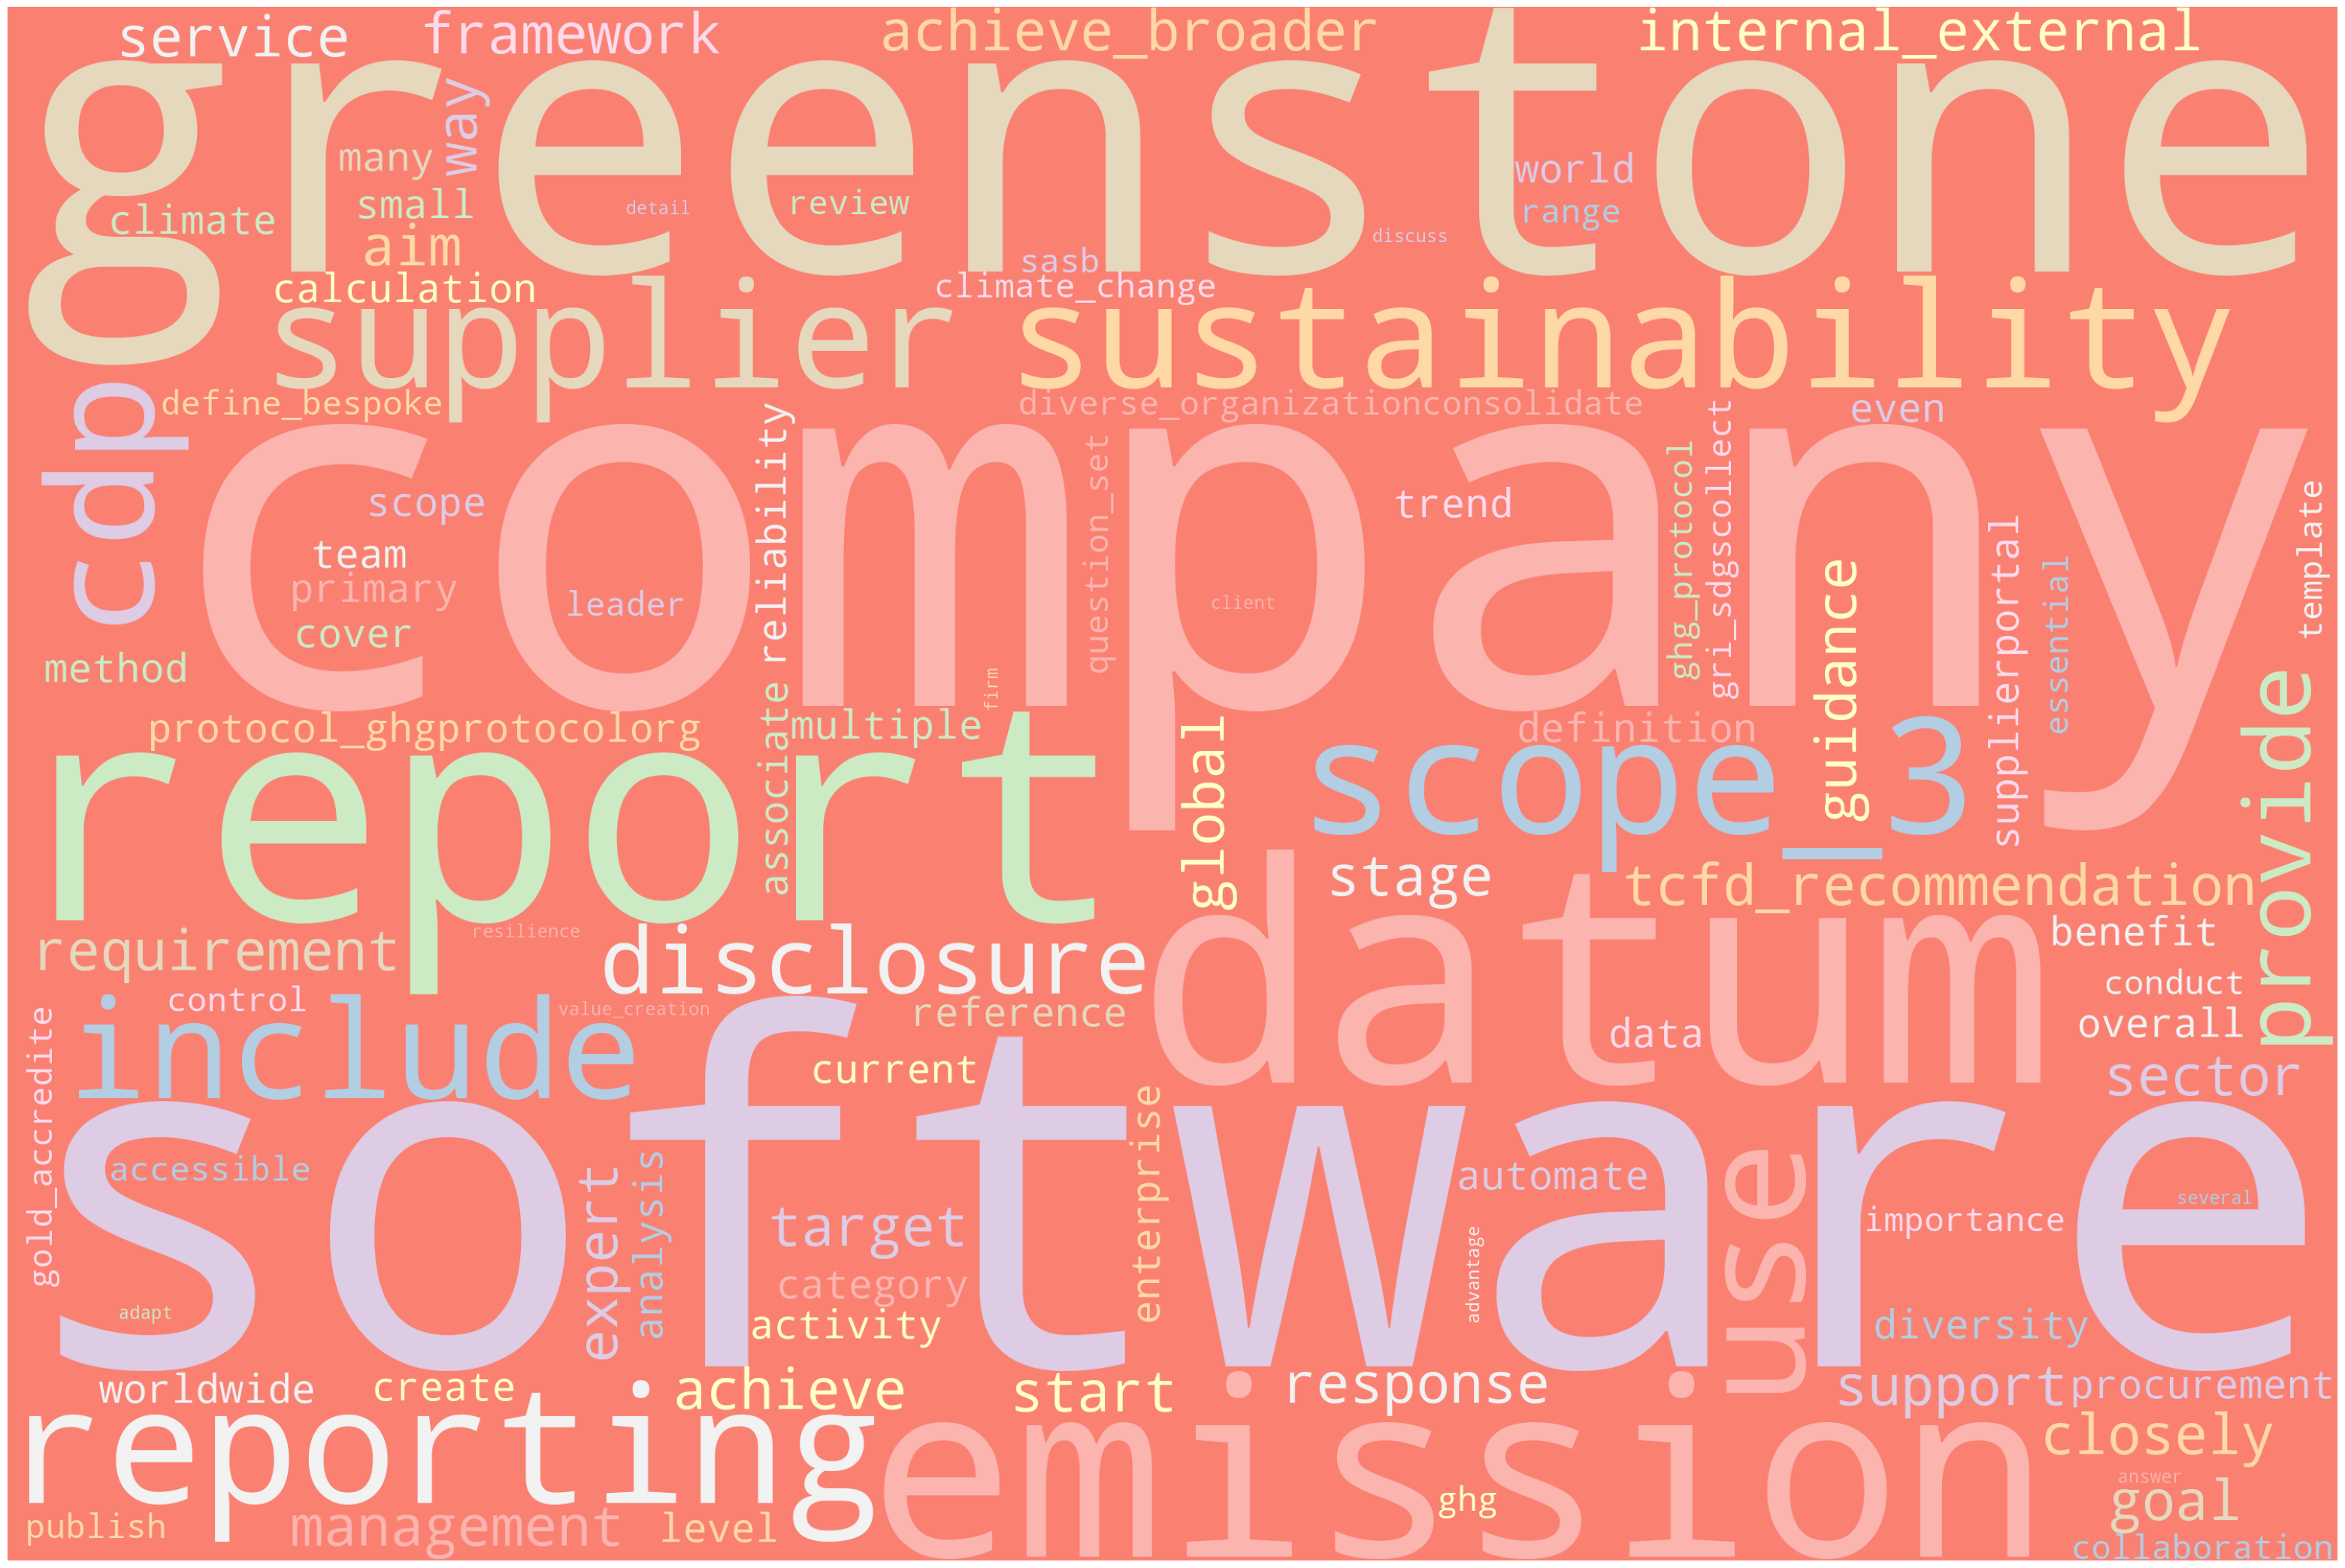

In [362]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
# Import package

# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = stop_words).generate(wordclouddeneme)
# Plot
plot_cloud(wordcloud)

In [363]:
z=df['Keywords'].astype(str)
z
list=[]
for i in range(len(z)):
    for j in range(10):
        list.append(df['Keywords'][i][j])
list

['company',
 'software',
 'greenstone',
 'report',
 'datum',
 'emission',
 'reporting',
 'scope_3',
 'sustainability',
 'supplier',
 'cdp',
 'use',
 'include',
 'disclosure',
 'provide',
 'tcfd_recommendation',
 'global',
 'requirement',
 'target',
 'goal',
 'framework',
 'support',
 'management',
 'internal_external',
 'service',
 'response',
 'achieve_broader',
 'expert',
 'way',
 'closely',
 'start',
 'aim',
 'stage',
 'sector',
 'guidance',
 'achieve',
 'protocol_ghgprotocolorg',
 'trend',
 'worldwide',
 'definition',
 'category',
 'cover',
 'scope',
 'method',
 'associate',
 'reference',
 'primary',
 'supplierportal',
 'overall',
 'reliability',
 'climate',
 'many',
 'here',
 'level',
 'team',
 'enterprise',
 'world',
 'current',
 'diversity',
 'small',
 'benefit',
 'procurement',
 'calculation',
 'data',
 'analysis',
 'create',
 'even',
 'activity',
 'automate',
 'multiple',
 'diverse_organizationconsolidate',
 'climate_change',
 'sasb',
 'gri_sdgscollect',
 'template',
 'define_

In [364]:
pd.Series(list)

0              company
1             software
2           greenstone
3               report
4                datum
             ...      
15055    collaboration
15056          control
15057          publish
15058           leader
15059          conduct
Length: 15060, dtype: object

In [365]:
import seaborn as sns
import matplotlib.pyplot as plt
y=pd.Series(list).apply(lambda x: x.split(', ') if isinstance(x, str) and x.strip() else [])
print(y)

0              [company]
1             [software]
2           [greenstone]
3               [report]
4                [datum]
              ...       
15055    [collaboration]
15056          [control]
15057          [publish]
15058           [leader]
15059          [conduct]
Length: 15060, dtype: object


In [366]:
keywords_list = [keyword for sublist in y for keyword in sublist]
print(keywords_list)
# Count the occurrences of each keyword
keyword_counts = pd.Series(keywords_list).value_counts()
type(keyword_counts)

['company', 'software', 'greenstone', 'report', 'datum', 'emission', 'reporting', 'scope_3', 'sustainability', 'supplier', 'cdp', 'use', 'include', 'disclosure', 'provide', 'tcfd_recommendation', 'global', 'requirement', 'target', 'goal', 'framework', 'support', 'management', 'internal_external', 'service', 'response', 'achieve_broader', 'expert', 'way', 'closely', 'start', 'aim', 'stage', 'sector', 'guidance', 'achieve', 'protocol_ghgprotocolorg', 'trend', 'worldwide', 'definition', 'category', 'cover', 'scope', 'method', 'associate', 'reference', 'primary', 'supplierportal', 'overall', 'reliability', 'climate', 'many', 'here', 'level', 'team', 'enterprise', 'world', 'current', 'diversity', 'small', 'benefit', 'procurement', 'calculation', 'data', 'analysis', 'create', 'even', 'activity', 'automate', 'multiple', 'diverse_organizationconsolidate', 'climate_change', 'sasb', 'gri_sdgscollect', 'template', 'define_bespoke', 'question_set', 'range', 'ghg_protocol', 'gold_accredite', 'acces

pandas.core.series.Series

In [367]:
# Convert to DataFrame and reset index for Seaborn
word_df = keyword_counts.reset_index()
word_df.columns = ['word', 'count']

In [368]:
word_df

word  count
0          company    166
1         automate    166
2             even    166
3           create    166
4         analysis    166
..             ...    ...
95         several     12
96          answer     12
97         discuss     12
98      resilience     12
99  value_creation     12

[100 rows x 2 columns]

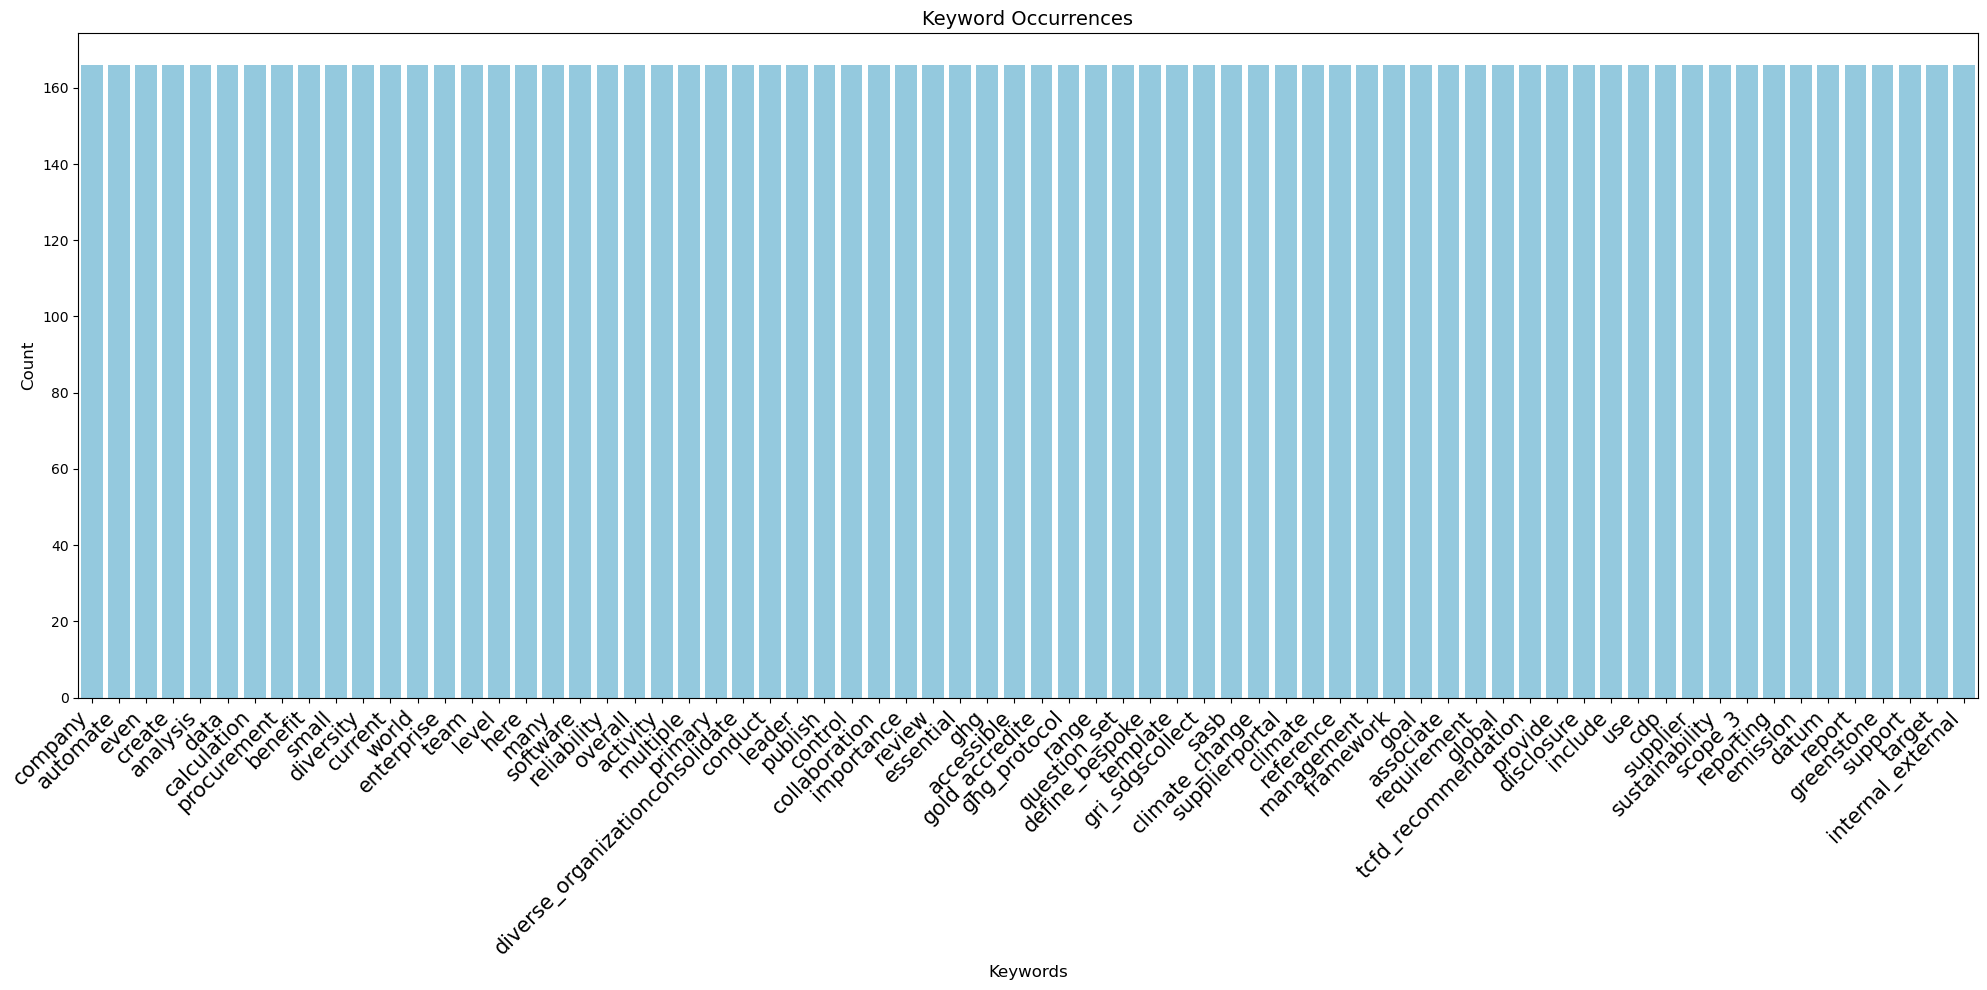

In [369]:
# Filter words with count > 1
filtered_word_df = word_df[word_df['count'] >5]
# Create a barplot
# Select the top 20 words
top_20_words = word_df.head(70)
plt.figure(figsize=(20, 10))
sns.barplot(
    x='word', 
    y='count', 
    data=top_20_words, 
   # palette='coolwarm',
   # edgecolor='black'  # Adds a border for clarity
    color='skyblue'
)

# Customize plot
#plt.figure(figsize=(40, 30))
plt.title('Keyword Occurrences', fontsize=14)
plt.xlabel('Keywords', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()